In [1]:
#http://alexanderfabisch.github.io/t-sne-in-scikit-learn.html
#https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html #PCA
#https://stackoverflow.com/questions/56777557/indexerror-when-ploting-sklearn-manifold-tsne

#remove na from data for tsne 

from time import time
import numpy as np
import pandas as pd
#plotting library
import matplotlib.pyplot as plt 
from matplotlib import offsetbox
#plotting library
import seaborn as sns 
#plotting library
from plotnine import *  
from sklearn import (manifold,datasets, decomposition, ensemble,
             discriminant_analysis, random_projection)
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
#import pyreadr
#import fbprophet
from collections import OrderedDict, defaultdict


Unable to open EPSG support file gcs.csv.  Try setting the GDAL_DATA environment variable to point to the directory containing EPSG csv files.


In [2]:
#open csv file with pandas
angio=pd.read_csv('Pressure_tracing-deID.csv')

#Time - time between points
#Pa -  Aortic pressure
#Pa mean - cycle MAP
#Pd - distal pressure
#Pd mean -  average cycle Pd 
#Pd/Pa - ratio b/w Pa mean and Pd mean. the "/" sometimes causes some problems if you want I can substitute it with "_"
#Hear Rate 
#ECG - ecg does not actually have any significant value in it because the cath lab does not use this system to get the ecg. So to split the cycles I find that what works best is smoothing the curve (I use savitzky golay filter) and then use the derivative to find where the cycle ends. To identify diastole I use the second derivative to find the diacritic notch in the aortic trace.



#create data frame
angio_df=pd.DataFrame(angio)

#note that a rows have no data
angio_df


,ID,Positive,Definitions,0,1,2,3,4,5,6,...,11444,11445,11446,11447,11448,11449,11450,11451,11452,11453
0,1,Negative,FFR_Time,0.000000,0.010000,0.020000,0.030000,0.040000,0.050000,0.060000,...,114.440000,114.450000,114.460000,114.470000,114.48000,114.49000,114.500000,114.510000,114.520000,114.53000
1,1,Negative,FFR_Pa,80.600000,80.300000,78.800000,77.900000,77.100000,76.100000,75.600000,...,63.000000,64.100000,65.200000,66.700000,71.60000,78.30000,86.700000,93.800000,97.500000,98.30000
2,1,Negative,FFR_Pa mean,95.500000,95.500000,95.500000,95.500000,95.500000,95.500000,95.500000,...,85.300000,85.300000,85.200000,85.200000,85.10000,85.10000,85.000000,85.000000,85.000000,85.10000
3,1,Negative,FFR_Pd,79.800000,79.700000,79.000000,78.500000,77.600000,76.700000,76.100000,...,63.400000,64.600000,66.300000,68.000000,71.80000,78.30000,85.700000,91.200000,94.100000,96.80000
4,1,Negative,FFR_Pd mean,95.700000,95.700000,95.700000,95.700000,95.700000,95.700000,95.700000,...,85.100000,85.100000,85.000000,85.000000,84.90000,84.90000,84.800000,84.800000,84.900000,84.90000
5,1,Negative,FFR_Pd/Pa,1.002090,1.002090,1.002090,1.002090,1.002090,1.002090,1.002090,...,0.997655,0.997655,0.997653,0.997653,0.99765,0.99765,0.997647,0.997647,0.998824,0.99765
6,1,Negative,FFR_Heart rate,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,...,84.000000,84.000000,84.000000,84.000000,84.00000,84.00000,84.000000,84.000000,84.000000,84.00000
7,2,Positive,FFR_Time,0.000000,0.010000,0.020000,0.030000,0.040000,0.050000,0.060000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2,Positive,FFR_Pa,55.500000,55.100000,54.900000,54.400000,54.300000,54.300000,54.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2,Positive,FFR_Pa mean,70.400000,70.400000,70.400000,70.400000,70.400000,70.400000,70.400000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
#remove NA from columns
angio_df = angio_df.dropna(axis='columns')
angio_df

,ID,Positive,Definitions,0,1,2,3,4,5,6,...,8475,8476,8477,8478,8479,8480,8481,8482,8483,8484
0,1,Negative,FFR_Time,0.000000,0.010000,0.020000,0.030000,0.040000,0.050000,0.060000,...,84.75000,84.76000,84.77000,84.780000,84.790000,84.800000,84.810000,84.820000,84.830000,84.840000
1,1,Negative,FFR_Pa,80.600000,80.300000,78.800000,77.900000,77.100000,76.100000,75.600000,...,113.00000,114.10000,113.60000,113.100000,112.000000,111.700000,111.000000,109.500000,106.900000,103.000000
2,1,Negative,FFR_Pa mean,95.500000,95.500000,95.500000,95.500000,95.500000,95.500000,95.500000,...,88.30000,88.30000,88.30000,88.200000,88.200000,88.200000,88.200000,88.200000,88.200000,88.200000
3,1,Negative,FFR_Pd,79.800000,79.700000,79.000000,78.500000,77.600000,76.700000,76.100000,...,112.30000,113.20000,113.70000,113.500000,113.100000,112.300000,111.500000,109.800000,107.000000,103.400000
4,1,Negative,FFR_Pd mean,95.700000,95.700000,95.700000,95.700000,95.700000,95.700000,95.700000,...,85.90000,85.90000,85.90000,85.800000,85.800000,85.800000,85.800000,85.800000,85.800000,85.800000
5,1,Negative,FFR_Pd/Pa,1.002090,1.002090,1.002090,1.002090,1.002090,1.002090,1.002090,...,0.97282,0.97282,0.97282,0.972789,0.972789,0.972789,0.972789,0.972789,0.972789,0.972789
6,1,Negative,FFR_Heart rate,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,...,83.00000,83.00000,83.00000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000
7,2,Positive,FFR_Time,0.000000,0.010000,0.020000,0.030000,0.040000,0.050000,0.060000,...,84.75000,84.76000,84.77000,84.780000,84.790000,84.800000,84.810000,84.820000,84.830000,84.840000
8,2,Positive,FFR_Pa,55.500000,55.100000,54.900000,54.400000,54.300000,54.300000,54.500000,...,68.80000,67.30000,66.00000,65.400000,64.700000,63.900000,62.700000,61.700000,60.800000,60.000000
9,2,Positive,FFR_Pa mean,70.400000,70.400000,70.400000,70.400000,70.400000,70.400000,70.400000,...,68.50000,68.40000,68.40000,68.400000,68.400000,68.400000,68.300000,68.300000,68.300000,68.300000


In [4]:
#write to csv
angio_df.to_csv("Pressure_tracing-deID_trim.csv")

#data passed to R for data wrangling into long format

In [ ]:
#converting to long format
#https://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html
#angio_df_long=pd.wide_to_long(angio_df, stubnames='FFR', i=['ID'], j='Methods')
#angio_df_unstack=pd.MultiIndex.from_frame(angio_df)
#angio_df_unstack


In [10]:
angio_long=pd.read_csv('angio_long.csv')
#create data frame
angio_long_df=pd.DataFrame(angio_long)
angio_long_df

,Unnamed: 0,ID,Positive,Index,Pa,Pd
0,1,1,Negative,0,80.6,79.8
1,2,1,Negative,1,80.3,79.7
2,3,1,Negative,10,72.7,75.5
3,4,1,Negative,100,76.0,76.8
4,5,1,Negative,1000,92.7,91.4
...,...,...,...,...,...,...
16965,16966,2,Positive,995,92.3,86.1
16966,16967,2,Positive,996,94.3,85.9
16967,16968,2,Positive,997,93.2,85.8
16968,16969,2,Positive,998,93.9,85.5


In [13]:
#preparing data for tsne
#select columns-note difference with selecting one and multiple columns
X = angio_long_df [['Pa','Pd']]
y = angio_long_df['Positive']
X

,Pa,Pd
0,80.6,79.8
1,80.3,79.7
2,72.7,75.5
3,76.0,76.8
4,92.7,91.4
...,...,...
16965,92.3,86.1
16966,94.3,85.9
16967,93.2,85.8
16968,93.9,85.5


In [14]:
#initialise tsne
tsne = TSNE(n_components=2, random_state=0)
#perform tsne
tsne_obj= tsne.fit_transform(X)

In [15]:
#create data frame from results
#first dimension label X
#second dimension label Y
#outcome variable label Outcome
tsne_df = pd.DataFrame({'X':tsne_obj[:,0],
                        'Y':tsne_obj[:,1],
                        'Positive':y})

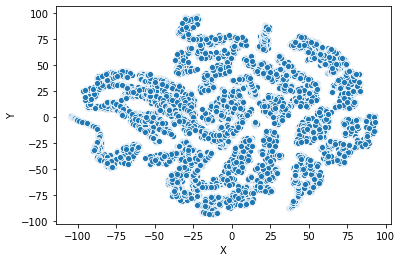

In [16]:
#plot with seaborn
sns.scatterplot(x="X", y="Y",
              data=tsne_df);

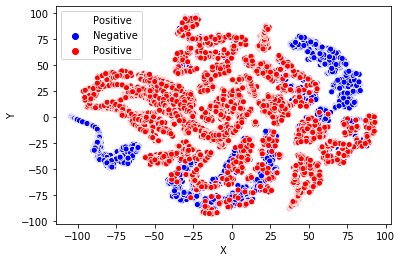

In [17]:
sns.scatterplot(x="X", y="Y",
              hue="Positive",
              palette=['blue','red'],
              legend='full',
              data=tsne_df);

In [18]:
#merge data frames by columns
df = pd.concat([angio_df,tsne_df],axis=1)
#check data
df.shape

(16970, 8491)

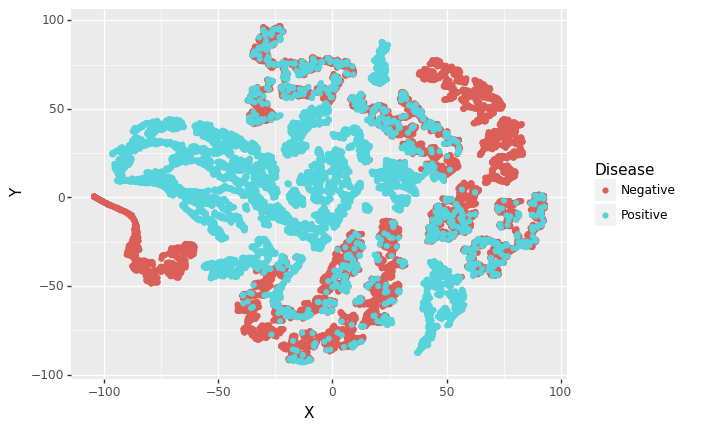

<ggplot: (-9223371883317654240)>

In [20]:
#ggplot style
#note the use of data merged from tsne output
(ggplot (tsne_df)
 + geom_point(aes('X ', 'Y',color='factor(Positive)')))+labs(color="Disease")